# Projet 6 : Catégorisez automatiquement des questions
# <u>B. Topic Modeling</u> <br/>

# Le contexte

Afin d'aider les utilisateurs de Stack Overflow dans leur soumission de question, nous devons mettre en place un système de suggestion de tags. Pour celà nous allons nous baser sur les techniques de machine learning capable en fonction du texte saisi par l'utilisateur de déterminer des tags pertinents.

Dans ce notebook nous allons essayer des approches non supervisées.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

from bs4 import BeautifulSoup
import unicodedata
import re
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize.toktok import ToktokTokenizer
from contractions import CONTRACTION_MAP


from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

%matplotlib inline

# 1. Chargement des données pré-traitées

Nous allons charger les données qui ont été préalablement nettoyées et traitées.

In [2]:
df = pd.read_csv('cleaned_data.csv')
#replace NaN by empty string
df = df.replace(np.nan, '', regex=True)

In [3]:
df.shape

(64432, 7)

In [4]:
df.head()

,TITLE,BODY,SCORE,TAGS,TITLE_P,BODY_P,TAGS_P
0,Java generics variable <T> value,<p>At the moment I am using the following code...,6,<java><generics>,java gener variabl valu,moment use follow code filter jpa reduc block ...,"['java', 'generics']"
1,How a value typed variable is copied when it i...,<blockquote>\n <p>Swift's string type is a va...,6,<swift><function><value-type>,valu type variabl copi pass function hold copi,swift string type valu type creat new string v...,"['swift', 'function', 'value-type']"
2,Error while waiting for device: The emulator p...,<p>I am a freshman for the development of the ...,6,<android><android-studio><android-emulator><avd>,error wait devic emul process avd kill,freshman develop andriod suffer odd question r...,"['android', 'android-studio', 'android-emulato..."
3,gulp-inject not working with gulp-watch,<p>I am using gulp-inject to auto add SASS imp...,10,<javascript><node.js><npm><gulp><gulp-watch>,gulp inject work gulp watch,use gulp inject auto add sass import newli cre...,"['javascript', 'node.js', 'npm', 'gulp', 'gulp..."
4,React - Call function on props change,<p>My TranslationDetail component is passed an...,12,<reactjs><react-router>,react call function prop chang,translationdetail compon pass id upon open bas...,"['reactjs', 'react-router']"


In [5]:
df.dtypes

TITLE      object
BODY       object
SCORE       int64
TAGS       object
TITLE_P    object
BODY_P     object
TAGS_P     object
dtype: object

La colonne TAGS_P est interprétée comme un chaîne de caractères. On va la forcer à être vue comme une list, ce qui sera plus simple pour les traitements.

In [6]:
from ast import literal_eval
df['TAGS_P'] = df['TAGS_P'].apply(literal_eval)

# 2. Transformation des données

## 2.1 Echantillonage

Nous avons plus de 64 000 posts. Nous allons nous concentrer sur un échantillon de 15 000 posts.

In [7]:
df_sample = df.sample(15000)

In [8]:
df_sample.shape

(15000, 7)

** Analysons le nombre de mots que contient ce corpus.**

In [9]:
my_counter = Counter()
for sentence in df_sample['TITLE_P']:
    my_counter.update(sentence.split())
for sentence in df_sample['BODY_P']:
    my_counter.update(sentence.split())
words_df = pd.DataFrame.from_dict(my_counter, orient='index')
words_df.reset_index(drop = False, inplace = True)
words_df= words_df.rename(columns={'index':'word', 0:'count'})

In [10]:
words_df.shape[0]

91945

=> Notre corpus est composé environ de  **90 000 mots.**

## 2.2 Filtre sur les tags les plus fréquents

Regardons déjà dans un premier temps le nombre d'occurences par tag.

In [11]:
counts = Counter()
for tags_list in df['TAGS_P']:
    counts.update(tags_list)
tags_df = pd.DataFrame.from_dict(counts, orient='index')
tags_df.reset_index(drop = False, inplace = True)
tags_df= tags_df.rename(columns={'index':'tag', 0:'count'})

La structures **tags_df** contient pour chacun des tags son occurence. <br/>
Gardons que les tags qui sont présents dans au moins 10 documents.

In [12]:
len(tags_df[tags_df['count'] > 10])

2114

Nous nous retrouvons donc avec un peu plus de 2100 tags (14000 tags dans le dataset original).

=> Filtrons maintenant notre sample en ne gardant que les posts contenant les tags les plus fréquents.

In [13]:
frequent_tags = tags_df[tags_df['count'] > 10]['tag'].tolist()

**frequent_tags** est la structure contenant les tags les plus présents.

In [14]:
df_sample['TAGS_P'] = df_sample['TAGS_P'].apply(lambda x: [w for w in x if w in frequent_tags] )
# On supprime les lignes qui n'ont plus de tags associés (car aucun n'est présent dans la liste frequent_tags)
df_sample = df_sample[df_sample.astype(str)['TAGS_P'] != '[]']

In [15]:
df_sample.shape

(14854, 7)

Notre dataset contient maintenant uniquement les posts avec tags fréquents.

## 2.3 Découpage en jeu entrainement et test

Découpons nos données en jeu d'entrainement et jeu de test pour nos algorithmes d'apprentissage.

In [16]:
X = df_sample[['TITLE', 'BODY','TITLE_P', 'BODY_P']]
Y = df_sample[['TAGS_P']]

70% des données pour entrainement et 30% pour les tests.

In [17]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X,Y,test_size = 0.3,random_state = 0, shuffle = True)

In [18]:
print("train", x_train.shape)
print("test ",x_test.shape)

train (10397, 4)
test  (4457, 4)


On concatène le titre et le body qui ont été pré-traités pour notre apprentissage.

In [19]:
x_train_text = x_train['TITLE_P'] + ' ' + x_train['BODY_P']

## 2.4 Bag of words

Pour pouvoir appliquer nos algorithmes de machine learning à nos données textuelles, il faut en extraire les features et représenter notre texte dans un modèle "mathématique".
Pour celà nous allons utiliser la modélisation **Bag of Words** qui va donner une représentation sous forme de matrice de nos données.

- min_df = 5 : le mot doit être présent au moins dans 5 documents
- max_df = 95% : si le mot est présent dans plus de 95% des documents, il ne nous aidera pas à trouver différencier les documents et on le supprime

In [20]:
cv = CountVectorizer(min_df=5, max_df=0.95)
data_vectorized = cv.fit_transform(x_train_text)
cv_matrix = data_vectorized.toarray()
cv_matrix.shape

(10397, 9080)

Voyons maintenant à quoi ressemble notre matrice.

In [21]:
#get all unique words in the corpus
tf_feature_names = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=tf_feature_names).head()

,aa,aaa,aaaa,aac,aapt,aar,ab,abandon,abbrevi,abc,...,zn,zone,zoneddatetime,zoom,zsh,zu,zygoteinit,zza,zzb,µs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Quels sont les mots les plus communs dans nos documents ?

In [22]:
voc_freq_df = pd.DataFrame([list(a) for a in zip(tf_feature_names, np.asarray(cv_matrix.sum(axis=0)).ravel())])
voc_freq_df.columns = ['word', 'count']
voc_freq_df.set_index('word', inplace=True)
voc_freq_df=voc_freq_df.sort_values('count', ascending=False)
voc_freq_df.head()

,count
word,
use,13849
android,9485
class,8724
error,8158
get,8033


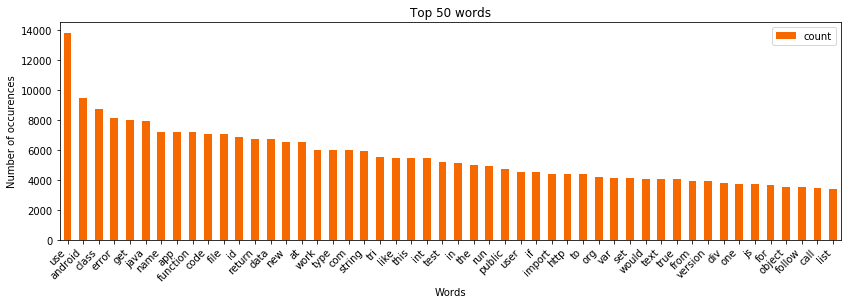

In [23]:
ax = voc_freq_df.head(50).plot(kind = 'bar', figsize = (14,4), color="#f56900")
plt.setp(ax.get_xticklabels(), rotation = 45, ha = 'right')
plt.title('Top 50 words', fontsize = 'large')
plt.xlabel('Words')
plt.ylabel('Number of occurences')
plt.show()

=> use, android, class, error, ... sont très fréquents

####  Sparsicity de la matrice

Regardons le pourcentage de cellules non égales à 0.

In [24]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity:  {:.2f} %".format( ((data_dense > 0).sum()/data_dense.size)*100, "%"))

Sparsicity:  0.67 %


# 3. Topics Modeling LDA

Essayons LDA (Allocation de Dirichlet Latente) pour modéliser les sujets.

## 3.1 Construction du modèle et tuning

Nous allons utiliser la recherche sur grille pour trouver les meilleurs valeurs des hyper-paramètres.

In [25]:
# Define Search Param
search_params = {'n_components': [10, 20, 30, 50, 70, 100 ], 'learning_method':['batch'], 'max_iter':[10]}
#search_params = {'n_components': [20 ], 'learning_method':['batch'], 'max_iter':[10]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
lda_model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
lda_model.fit(data_vectorized)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [10, 20, 30, 50, 70, 100], 'learning_method': ['batch'], 'max_iter': [10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Voyons les hyper-paramètres qui donnent la meilleure performance.

In [26]:
lda_model.best_params_

{'learning_method': 'batch', 'max_iter': 10, 'n_components': 20}

Nous pouvons partir sur 20 topics.

In [27]:
best_lda_model = lda_model.best_estimator_

In [28]:
lda_output = best_lda_model.transform(data_vectorized)

In [29]:
lda_output.shape

(10397, 20)

### Evaluation

Regardons le score de perplexité et likehood de notre modèle.

In [30]:
print("Perplexity : ",best_lda_model.perplexity(data_vectorized))

Perplexity :  1092.04400832


In [31]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", best_lda_model.score(data_vectorized))

Log Likelihood:  -9862282.18511


## 3.2 Analyse des résultats

### Topics / Words

Affichage de la matrice topics / words.

In [32]:
# liste des topics
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# Topic-Keyword Matrice
df_topic_keywords = pd.DataFrame(best_lda_model.components_)
df_topic_keywords.columns = tf_feature_names
df_topic_keywords.index = topicnames

df_topic_keywords

,aa,aaa,aaaa,aac,aapt,aar,ab,abandon,abbrevi,abc,...,zn,zone,zoneddatetime,zoom,zsh,zu,zygoteinit,zza,zzb,µs
Topic0,0.050000,0.050000,0.050000,0.050000,0.050000,0.05,0.050000,1.340893,0.050000,0.050000,...,0.050000,0.050000,0.05,0.050000,3.157327,0.050000,0.05,0.05,0.05,0.0500
Topic1,0.050000,5.021954,0.050000,0.050000,0.050000,0.05,3.433859,0.050000,0.050000,0.050000,...,0.050000,0.050000,0.05,14.195918,0.050000,0.050000,0.05,0.05,0.05,0.0500
Topic2,0.050000,0.050000,0.050000,0.050000,0.050000,0.05,0.050000,0.050000,0.050000,0.050000,...,1.050000,145.620624,0.05,0.050000,0.050000,0.050000,0.05,0.05,0.05,0.0500
Topic3,0.050000,0.050000,0.050000,0.050000,0.050000,0.05,0.050000,0.050000,0.050000,2.860864,...,8.627394,0.050000,0.05,84.955824,0.050000,0.050000,0.05,0.05,0.05,0.0500
Topic4,16.867455,0.050000,0.050000,0.050000,0.050000,0.05,20.056827,0.050000,0.050000,0.751524,...,0.050000,5.374146,0.05,0.050000,0.050000,3.304777,0.05,0.05,0.05,0.0500
Topic5,5.134391,0.050000,13.045167,1.392691,0.050000,0.05,4.120866,0.050000,0.050000,0.050000,...,4.480275,0.050000,0.05,0.050000,0.050000,0.050000,0.05,0.05,0.05,0.0500
Topic6,0.050000,0.050000,0.050000,0.050000,0.050000,0.05,0.050000,0.050000,2.050000,0.050000,...,0.050000,0.050000,0.05,0.050000,0.050000,0.340604,0.05,0.05,0.05,0.0500
Topic7,0.050000,0.050000,0.050000,0.050000,0.050000,0.05,0.050000,0.050000,0.050000,3.337443,...,0.050000,0.050000,30.05,0.050000,0.050000,0.050000,236.05,36.05,17.05,0.0500
Topic8,3.310688,0.050000,0.050000,0.050000,42.988598,118.05,0.050000,0.050000,0.050000,0.050000,...,0.050000,0.050000,0.05,0.050000,0.050000,0.050000,0.05,0.05,0.05,0.0500
Topic9,2.161898,11.050000,0.054833,0.050000,0.050000,0.05,5.842846,0.050877,0.050000,111.589559,...,0.050000,0.050000,0.05,0.050000,0.050000,19.504619,0.05,0.05,0.05,2.8735


In [33]:
# Méthode qui retourne pour chacun des topics le top "n_words" mots
def show_topics(feature_names, tp_model, n_words=20):
    keywords = np.array(feature_names)
    topic_keywords = []
    for topic_weights in tp_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [34]:
topic_keywords = show_topics(tf_feature_names, best_lda_model, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,user,app,git,use,token,login,firebas,password,email,auth
Topic 1,div,px,class,width,style,text,height,color,content,background
Topic 2,js,angular,import,node,app,react,from,compon,error,component
Topic 3,self,size,frame,button,let,point,plot,imag,scale,xs
Topic 4,http,request,php,json,server,api,get,com,error,url
Topic 5,let,thread,call,if,code,self,error,task,async,string
Topic 6,this,state,return,product,const,function,test,react,as,cell
Topic 7,java,at,org,com,jar,spark,apache,springframework,lang,internal
Topic 8,android,com,app,support,build,google,compile,project,error,version
Topic 9,int,class,std,type,function,return,foo,string,void,use


Nous pouvons interpréter certains topics : <br/>
- le sujet 1 : Tableau HTML
- Le sujet 7 : Androïd 
- Le sujet 9 : Requêtes HTTP 
- Le sujet 15 : Microsoft / .Net
- Le sujet 16 : Java / Apache
- Le sujet 17 : Python
- Le sujet 19 : System / Installation
...

###  Docs / Topics

Voyons maintenant le topic associé à quelques documents.

In [35]:
'''
Affiche pour chacun des topics, le top n documents qui sont les plus pertinent pour ce topic.
@H : word_to_topics matrix
@W : topics_to_docs matrix
'''
def display_topics(H, W, feature_names, documents, targets, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print ("Topic %d : " % (topic_idx) + " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print ("Doc",doc_index," Title:", documents.iloc[doc_index].TITLE[0:60],
                   "- Tags:", targets.iloc[doc_index].TAGS_P)
        print("")

In [37]:
display_topics(best_lda_model.components_, lda_output, tf_feature_names, x_train, y_train, 10, 2)

Topic 0 : user app git use token login firebas password email auth
Doc 1951  Title: LinkedIn API Refresh Access Token (May 2017) - Tags: ['linkedin', 'access-token', 'linkedin-api']
Doc 5776  Title: Why can't I store an oauth refresh token in the browser? - Tags: ['security', 'authentication', 'web-applications']

Topic 1 : div px class width style text height color content background
Doc 9641  Title: Accounting for Scrollbar Width When Positioning Element - Tags: ['css']
Doc 9681  Title: Bootstrap Mobile Menu 100% - Tags: ['html', 'css', 'twitter-bootstrap', 'css3']

Topic 2 : js angular import node app react from compon error component
Doc 7731  Title: Angular 2: How to tell SystemJS to use a bundle? - Tags: ['javascript', 'angular', 'bundle', 'systemjs']
Doc 6663  Title: ng2-bootstrap not working in Angular 2 ('alert' is not a kno - Tags: ['angular']

Topic 3 : self size frame button let point plot imag scale xs
Doc 7628  Title: How to crop a UIImage without losing it's scale proper

- **Stockons pour chaque document, le topic qui a la plus grande prédominance**

In [38]:
# id des posts
docnames = ["Doc" + str(i) for i in range(len(x_train))]

# On crée un dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 4), columns=topicnames, index=docnames)

# On rajoute une colonne contenant le numéro du topic prédominant
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['Dominant_Topic'] = dominant_topic

In [39]:
df_document_topic.head(10)

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Dominant_Topic
Doc0,0.1031,0.0001,0.0001,0.0001,0.0001,0.0001,0.0470,0.0001,0.0001,0.4124,...,0.0001,0.0001,0.3095,0.0266,0.0999,0.0001,0.0001,0.0001,0.0001,9
Doc1,0.0017,0.0017,0.0017,0.5441,0.0017,0.0017,0.0017,0.0017,0.0017,0.0017,...,0.4259,0.0017,0.0017,0.0017,0.0017,0.0017,0.0017,0.0017,0.0017,3
Doc2,0.0004,0.7790,0.0301,0.0291,0.0004,0.0004,0.0243,0.0004,0.0004,0.0004,...,0.0004,0.0004,0.0490,0.0004,0.0829,0.0004,0.0004,0.0004,0.0004,1
Doc3,0.0021,0.0021,0.0021,0.0021,0.0021,0.0021,0.0021,0.0021,0.0021,0.9604,...,0.0021,0.0021,0.0021,0.0021,0.0021,0.0021,0.0021,0.0021,0.0021,9
Doc4,0.9756,0.0013,0.0013,0.0013,0.0013,0.0013,0.0013,0.0013,0.0013,0.0013,...,0.0013,0.0013,0.0013,0.0013,0.0013,0.0013,0.0013,0.0013,0.0013,0
Doc5,0.0008,0.0008,0.0008,0.0008,0.0008,0.0008,0.0008,0.0008,0.0315,0.0008,...,0.0662,0.0008,0.0008,0.0008,0.0008,0.0008,0.0008,0.0008,0.8883,19
Doc6,0.0002,0.0002,0.9479,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,...,0.0002,0.0002,0.0002,0.0002,0.0487,0.0002,0.0002,0.0002,0.0002,2
Doc7,0.0003,0.0523,0.0305,0.0003,0.0003,0.0003,0.0692,0.0003,0.0003,0.1510,...,0.1281,0.0003,0.0003,0.0857,0.0556,0.0003,0.0003,0.0003,0.0904,10
Doc8,0.1793,0.0003,0.0003,0.0003,0.0432,0.4191,0.1252,0.0003,0.0003,0.0461,...,0.0003,0.1822,0.0003,0.0003,0.0003,0.0003,0.0003,0.0003,0.0003,5
Doc9,0.0013,0.0013,0.0882,0.0013,0.5725,0.0013,0.0013,0.0013,0.0013,0.0013,...,0.0013,0.0013,0.0013,0.0013,0.0013,0.0013,0.1948,0.1245,0.0013,4


## 3.3 Préparation pour prédiction

Pour nous aider à faire nos prédictions, nous allons construire une matrice tags par topic.<br/>
Pour la construire, nous allons :
- Pour chaque tag_i et chaque topic_j
    - Sommer la probabilité d’appartenance au topic_j des documents contenant le tag_i. 
    - Nous allons normaliser cette somme en faisant une moyenne sur le nombre de documents qui contiennent le tag_i

|         | tag_1 | tag_2 | ... |tag_m | 
|---------|-------|-------|-----|------|
| **topic_1**  |  xxx  | xxx   | ... | xxx  | 
|**topic_2** |  xxx  | xxx   | ... | xxx  | 
|...      |  xxx  | xxx   | ... | xxx  |
|**topic_n**      |  xxx  | xxx   | ... | xxx  |


- Commençons par stocker pour chacun des tags, les documents qui y sont liés.

In [40]:
'''
Retourne la liste des positions (à partir index) dans data des documents contenant le tag
'''
def getTagDocPositions(tag, data):
    doc_indexes = data[data['TAGS_P'].apply(lambda x: True  if tag in x else False)].index.values
    return [(lambda x: data.index.get_loc(x))(x) for x in doc_indexes]

In [41]:
documents_by_tags = {}
for tag in frequent_tags :
    docs_index = getTagDocPositions(tag, y_train)
    documents_by_tags[tag] = docs_index

Le dictionnaire **documents_by_tags** associe à un tag, la liste des documents contenant ce tag (la position du document dans le dataframe de training)

- Construisons maintenant notre matrice tags par topics.

In [42]:
'''
@model : 
@ ft : list of frequent tags
@ d_by_t : dictionary of list of documents containing the tag (key)
'''
def buildTagByTopicsMatrix(topics_modeling_algo, tm_output, ft,  d_by_t) :
    tag_by_topics_ = np.zeros([topics_modeling_algo.n_components,len(ft)])
    for topic_idx in range(topics_modeling_algo.n_components):
        for tag_idx, tag in enumerate(ft):
            docs_pos = d_by_t[tag]
            topic_score = 0
            for d in docs_pos :
                topic_score += tm_output[d][topic_idx]
                if topic_score > 0 :
                    #tags_by_topics[topic_idx][tag_idx]=topic_score/len(docs_pos)
                    tag_by_topics_[topic_idx][tag_idx]=topic_score
    return tag_by_topics_

In [43]:
tags_by_topics_lda = buildTagByTopicsMatrix(best_lda_model,lda_output, frequent_tags, documents_by_tags )

In [44]:
tags_by_topics_lda

array([[  2.77178375e+01,   4.00388640e-01,   2.46160939e+01, ...,
          7.82686177e-03,   5.71660404e-01,   6.80596649e-02],
       [  5.80856938e+00,   9.47680639e-02,   9.32352613e+00, ...,
          3.82472548e-03,   1.41218401e-03,   1.25131918e-03],
       [  9.76653958e+00,   2.13439493e-01,   2.57517194e+00, ...,
          3.32406951e-02,   5.83985248e-01,   1.17308620e+00],
       ..., 
       [  4.02894353e+01,   2.25488651e-01,   4.25896063e+00, ...,
          2.60066986e-01,   1.41218400e-03,   1.25131917e-03],
       [  4.62186997e+01,   2.75858209e+00,   4.45475941e+00, ...,
          3.82472552e-03,   1.41218399e-03,   1.25131917e-03],
       [  9.33823968e+00,   2.22331679e-02,   5.94182638e+00, ...,
          3.82472551e-03,   1.41218400e-03,   1.25131917e-03]])

- Ecrivons une méthode qui retourne, pour un numéro de topic donné, les _n_ tags les plus pertinents (ceux qui ont le meilleur score dans notre matrice)

In [45]:
'''
Retourne num_tags tags les plus pertinents associés au topic numéro topic_idx
'''
def getBestTagsForTopic(t_by_topics, f_t, topic_idx, num_tags) :
    tags_indices = np.argsort(-t_by_topics[topic_idx])[:num_tags]
    best_tags = [f_t[index] for index in tags_indices]
    return best_tags

## 3.4 Prédiction

### Text cleaning and processing

Reprenons le code des méthodes utilisées pour la partie cleaning du texte et pré-processing.

In [46]:
stopword_list = set(stopwords.words('english'))
tokenizer = ToktokTokenizer()

'''
Méthode qui permet de mettre les contractions dans une forme classique.
Méthode récupéré depuis github : (c) @dipanjanS
'''
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


# stemming of words
def stem_text(word) :
    porter = PorterStemmer()
    return porter.stem(word)


def getCleanedText(text) :
    # remove html tags
    text = BeautifulSoup(text, "lxml").get_text()
    
    # remove accented char
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    text = expand_contractions(text)
    
    # remove non alpha char
    text = re.sub('[\W\d_]', ' ', text)

    # convert to lower case
    text = text.lower()
  
    #remove extra newlines
    text = re.sub(r'[\r|\n|\r\n]+', ' ',text)
    
    # remove extra whitespace
    text = re.sub(' +', ' ', text)
    
    # Remove any single letter except 'c' (correspond au langage)
    text = ' '.join( [w for w in text.split() if len(w)>1 or w == 'c'] )
    
    # remove stopwords
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    meaningful_words = [token for token in tokens if token not in stopword_list]
    
    # stemming of words
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in meaningful_words]
    
    # join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( stemmed )) 

In [47]:
def getCleanedBody(body) :
    text = getCleanedBodyText(body)
    code = getCleanedBodyCode(body)
    return (text + ' ' + code).strip()

'''
Retrieve body text inside <p>,<h1>,<h2>,<li> tags and return the cleaned and normalized text
'''
def getCleanedBodyText(body) :
    ctext=""
    tags_list=['h1','h2','p','li']
    soup = BeautifulSoup(body, 'html.parser')
    for t in tags_list :
        blocks = soup.findAll(t)
        for block in blocks:
            ctext += " " + block.text    
    return getCleanedText(re.sub(' +',' ',ctext.strip()))

'''
Retrieve the code text inside the body
'''
def getCleanedBodyCode(body) :
    ctext=""
    soup = BeautifulSoup(body, 'lxml')
    code_blocks = soup.findAll('code')
    ctext=" ".join(list(map(lambda x : x.text, code_blocks )))
    table = str.maketrans('', '', string.punctuation)
    words = re.findall(r"[^\W\d_']+", ctext.lower())
    stripped = [w.translate(table) for w in words]
    return( " ".join( stripped ))

### Topic prediction

- Ecrivons une méthode qui va, par le biais de LDA, retrouver le topic prédominant d'un texte.

In [48]:
'''
Retourne le numéro de topic le plus pertinenent pour un poste (titre et texte)
'''
def getBestTopicForPost(title, body, vectorizer, tm_model) :
    text = getCleanedText(title) + ' ' + getCleanedBody(body)
    text_vectorized = vectorizer.transform([text])
    topic_probability_scores = tm_model.transform(text_vectorized)
    best_topicId = np.argmax(topic_probability_scores)
    return best_topicId

- Méthode qui va chercher dans la matrice tags/topics, les tags les plus pertinent pour un post.<br/>
Elle va d'abord déterminer le topic prédominant du post puis rechercher les tags.

In [49]:
'''
Retourne la liste de n tags les plus pertinents pour le post donné.
Se base pour celà de la matrice tags par topics.
'''
def getTagsPrediction(title, body, num_tag, t_by_topics, frequent_tags, vectorizer, tm_model ) :
    predicted_topic = getBestTopicForPost(title, body,vectorizer, tm_model ) 
    predicted_tags = getBestTagsForTopic(t_by_topics, frequent_tags, predicted_topic, num_tag)
    return predicted_tags

- Méthode qui prédit les tags d'une série de post.

In [50]:
'''
Retourne un dataframe contenant les prédictions de tags pour les posts contenant dans posts_df
@ post_df : le dataframe contenant les posts (title / body)
@ num_tag : le nombre de tags à prédire
@ t_by_topics : la matrice tags/topics utilisée pour la prédiction
@ f_tags : liste des tags les plus fréquents (même ordre que tags dans la matrice)
@ vectorizer : convertisseur à utiliser pour transformer texte en matrice de tokens et d'occurences.
@ tm_model : le modèle de topic modeling à utiliser
'''
def getPostsTagsPrediction(posts_df, num_tag, t_by_topics, f_tags, vectorizer, tm_model):
    y_predicted=posts_df.apply(lambda row: getTagsPrediction(row['TITLE'], row['BODY'], 
                                                             num_tag, t_by_topics, f_tags, vectorizer, tm_model),
                               axis=1)
    y_predicted_df = y_predicted.to_frame()
    y_predicted_df.columns = ['TAGS_P']
    return y_predicted_df

## 3.5 Evaluation de la méthode

- Méthode pour évaluer la qualité de nos prédictions

In [51]:
'''
Méthode permettant d'évaluer la qualité des prédictions en comparant les tags prédits aux tags réels.
calcule pour chaque post, le rapport entre le nombre de tags correctement prédits sur le nombre de tags réels.
retourne la moyenne de ces rapports.
'''

def predictionAccuracy(y_predicted, y_true) :
    tags_found=[]
    for index, row in y_predicted.iterrows():
        number_tags_found = 0
        for t in row['TAGS_P'] :
            if t in y_true.loc[index]['TAGS_P'] :
                number_tags_found +=1
        tags_found.append(number_tags_found/len(y_true.loc[index]['TAGS_P']))
    print("Accuracy of prediction :", np.mean(tags_found))

### Prédiction des topics pour notre jeu de tests

In [52]:
y_predicted_lda = getPostsTagsPrediction(x_test, 5, tags_by_topics_lda, frequent_tags, cv, best_lda_model)

In [53]:
y_predicted_lda.head()

,TAGS_P
7647,"[python, pandas, r, numpy, java]"
45706,"[php, c#, docker, javascript, node.js]"
33042,"[reactjs, javascript, react-native, angular, r..."
3510,"[android, javascript, ios, c#, java]"
45801,"[css, html, javascript, jquery, css3]"


### Evaluation de la prédiction du jeu de test

In [54]:
predictionAccuracy(y_predicted_lda, y_test)

Accuracy of prediction : 0.274721412011


### Evaluation de la prédiction d'un nouveau sample

In [55]:
df_test2 = df.sample(5000)
x_test2 = df_test2[['TITLE', 'BODY','TITLE_P', 'BODY_P']]
y_test2 = df_test2[['TAGS_P']]

In [56]:
y_predicted_test2 = getPostsTagsPrediction(x_test2, 5,tags_by_topics_lda,frequent_tags, cv,  best_lda_model )
result = predictionAccuracy(y_predicted_test2, y_test2)

Accuracy of prediction : 0.231293333333


# 4. NMF

Voyons maintenant la méthode NMF (Factorisation par matrices non négatives) pour prédire nos tags.

## 4.1 Vectorization du texte

Utilisons la métrique tf-idf (Term-Frequency - Inverse Document Frequency).

In [60]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=5)
tfidf_vectorized = tfidf_vectorizer.fit_transform(x_train_text)
tfidf_matrix = tfidf_vectorized.toarray()
tfidf_matrix.shape

Extracting tf-idf features for NMF...


(10397, 9080)

In [61]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

## 4.2 Modélisation

In [62]:
nmf_model = NMF(n_components=30, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf_vectorized)

In [63]:
nmf_output = nmf_model.transform(tfidf_vectorized)

In [64]:
nmf_output.shape

(10397, 30)

## 4.3 Analyse

### Topics / Words

In [65]:
topic_keywords = show_topics(tfidf_feature_names, nmf_model, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,use,would,like,way,code,one,time,work,set,want
Topic 1,android,layout,com,support,compile,view,gradl,google,parent,id
Topic 2,int,const,compil,void,return,char,main,struct,size,gcc
Topic 3,div,class,li,form,px,span,click,col,item,input
Topic 4,java,at,org,lang,activitythread,com,internal,apache,util,jar
Topic 5,js,node,webpack,script,npm,module,modules,src,loader,at
Topic 6,px,width,height,text,color,style,size,background,imag,font
Topic 7,class,public,void,private,method,new,static,this,object,override
Topic 8,angular,ng,cli,compon,ts,http,bootstrap,browser,core,use
Topic 9,react,nativ,render,native,compon,props,redux,state,use,prop


### Topics / Docs

In [66]:
topicnames = ["Topic" + str(i) for i in range(nmf_model.n_components)]

# id des posts
docnames = ["Doc" + str(i) for i in range(len(x_train))]

# On crée un dataframe
df_document_topic = pd.DataFrame(np.round(nmf_output, 4), columns=topicnames, index=docnames)

# On rajoute une colonne contenant le numéro du topic prédominant
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

In [67]:
df_document_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,dominant_topic
Doc0,0.0175,0.0000,0.0109,0.0000,0.0,0.0,0.0000,0.0545,0.0000,0.0000,...,0.0032,0.0000,0.0000,0.0067,0.0137,0.0,0.0,0.0000,0.0,7
Doc1,0.0235,0.0082,0.0000,0.0000,0.0,0.0,0.0244,0.0000,0.0000,0.0018,...,0.0000,0.0000,0.0013,0.0000,0.0000,0.0,0.0,0.0000,0.0,6
Doc2,0.0053,0.0000,0.0000,0.0128,0.0,0.0,0.1083,0.0000,0.0192,0.0000,...,0.0030,0.0009,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0,6
Doc3,0.0129,0.0000,0.0338,0.0000,0.0,0.0,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0,2
Doc4,0.0063,0.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0534,0.0000,0.0220,0.0,0.0,0.1418,0.0,28


## 4.4 Matrice Tags / Topics

In [68]:
tags_by_topics_nmf = buildTagByTopicsMatrix(nmf_model,nmf_output, frequent_tags, documents_by_tags )

In [69]:
tags_by_topics_nmf.shape

(30, 2114)

## 4.5 Prédiction

### Prédiction des topics pour notre jeu de tests

In [70]:
y_predicted_nmf = getPostsTagsPrediction(x_test, 5, tags_by_topics_nmf, frequent_tags, tfidf_vectorizer, nmf_model)

In [71]:
y_predicted_nmf.head()

,TAGS_P
7647,"[javascript, python, android, java, c#]"
45706,"[java, android, java-8, spring, android-studio]"
33042,"[css, html, javascript, android, ios]"
3510,"[css, html, javascript, android, ios]"
45801,"[css, html, javascript, android, ios]"


In [72]:
predictionAccuracy(y_predicted_lda, y_test)

Accuracy of prediction : 0.274721412011


### Evaluation de la prédiction du nouveau sample

In [73]:
y_predicted_test2 = getPostsTagsPrediction(x_test2, 5,tags_by_topics_nmf,frequent_tags, tfidf_vectorizer,  nmf_model )
result = predictionAccuracy(y_predicted_test2, y_test2)

Accuracy of prediction : 0.27112
